#### Objective: Explore FPL data to identify key insights for fantasy league predictions.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [15]:
print(player_reference_df.columns)


Index(['id', 'first_name', 'second_name', 'element_code'], dtype='object')


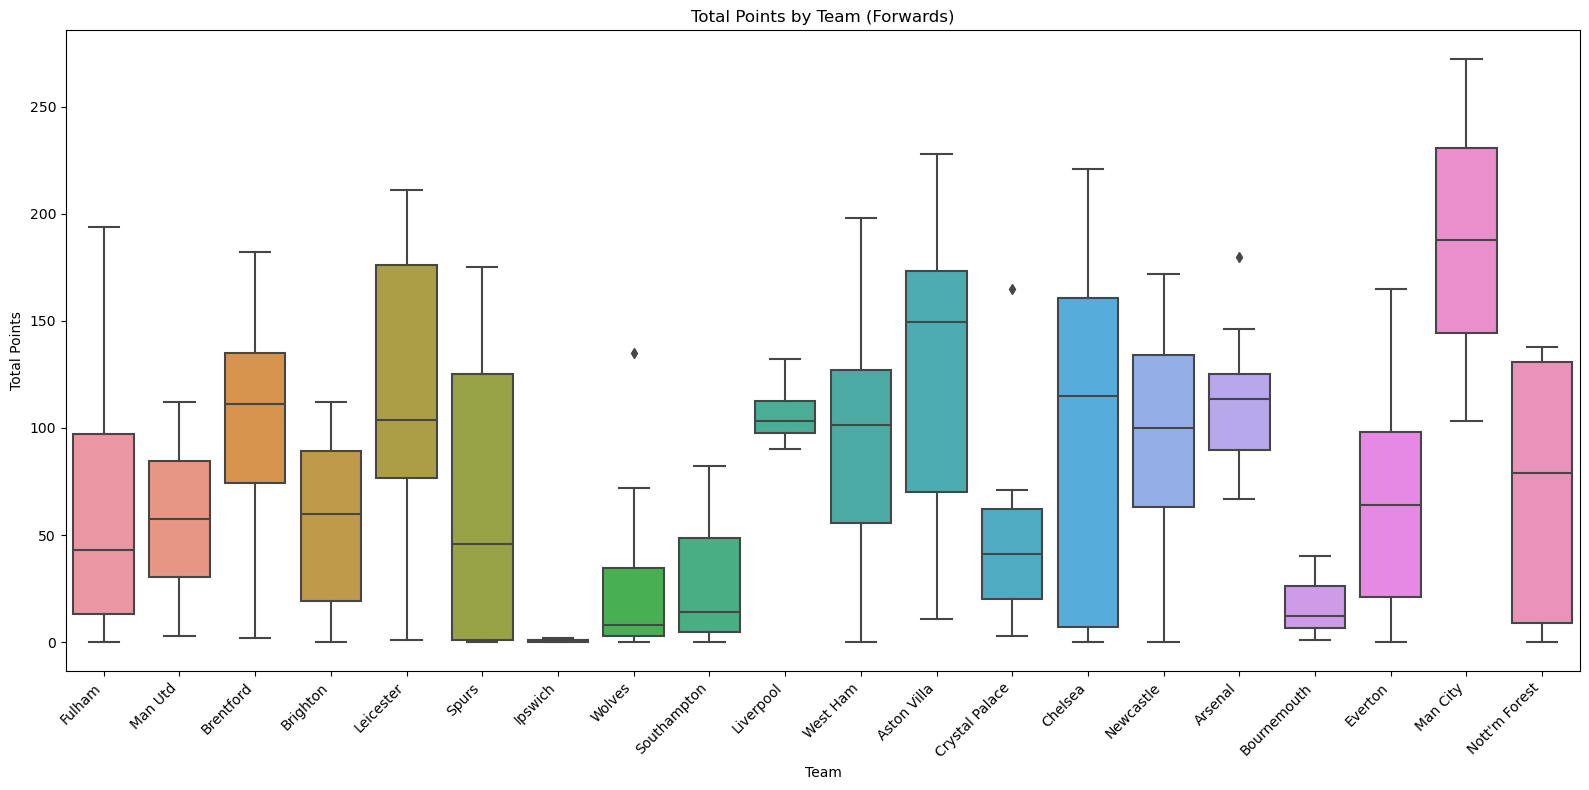

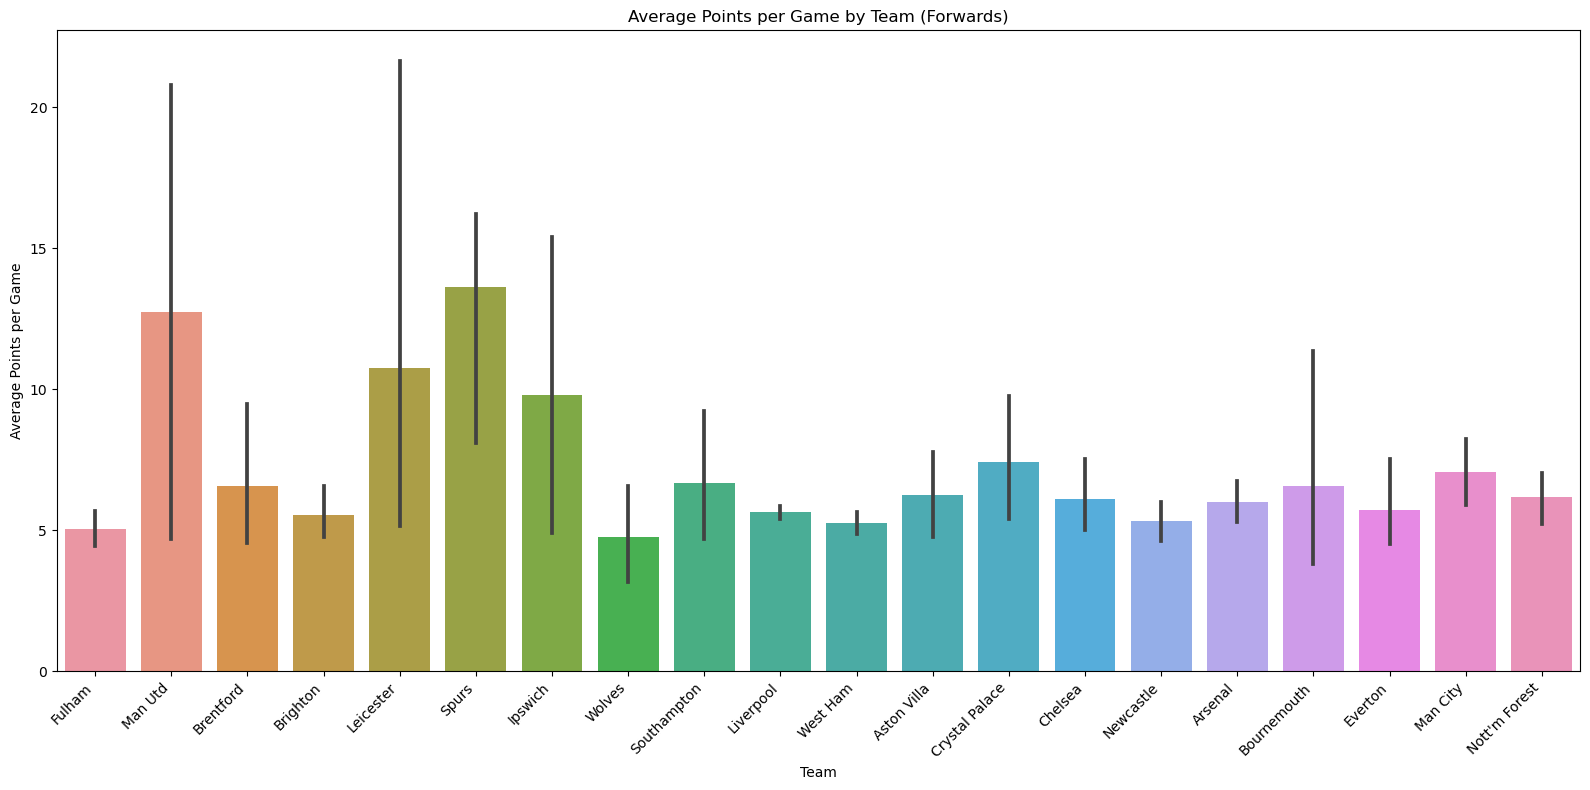


Summary Statistics for Teams (Forwards):
               total_points                             points_per_game  \
                       mean median        std  min  max            mean   
team_name                                                                 
Man City         187.500000  187.5  73.077584  103  272        7.069275   
Aston Villa      127.166667  149.5  81.959543   11  228        6.260114   
Leicester        115.750000  103.5  67.359236    1  211       10.758755   
Arsenal          112.333333  113.5  31.043469   67  180        5.984475   
Liverpool        107.000000  103.0  17.925773   90  132        5.649254   
Brentford        102.000000  111.0  58.901047    2  182        6.564687   
Chelsea           96.000000  115.0  78.554803    0  221        6.112739   
Newcastle         94.384615  100.0  54.435801    0  172        5.331590   
West Ham          90.250000  101.5  53.135254    0  198        5.258757   
Nott'm Forest     71.125000   79.0  55.928377    0  138   

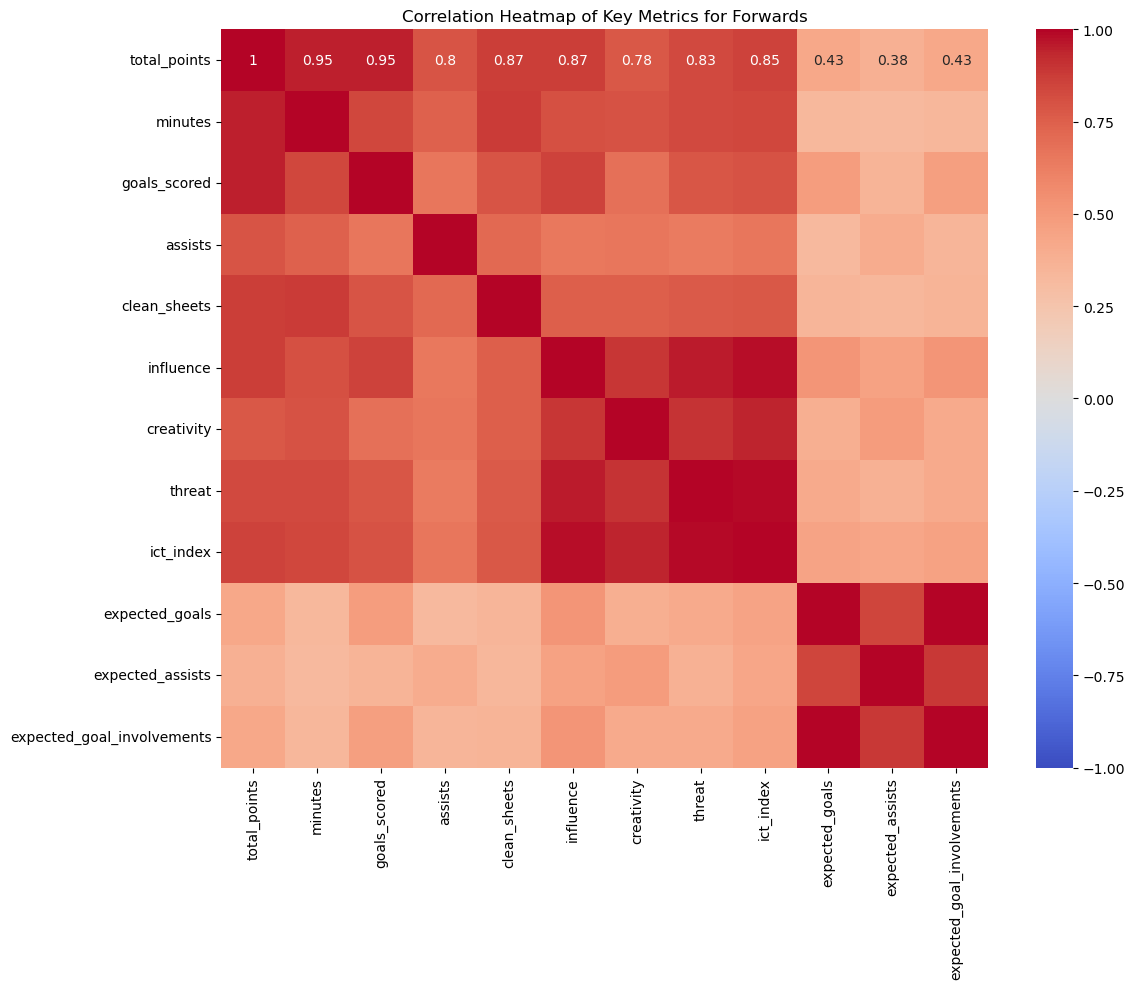

In [16]:
# Base path for cleaned data
base_cleaned_path = '../data/cleaned/'

# Load the cleaned forward data
forwards_df = pd.read_csv(os.path.join(base_cleaned_path, 'forward/forward_cleaned.csv'))
player_reference_df = pd.read_csv('../data/raw/player_reference.csv')

# Merge with player reference data to add names
forwards_df = forwards_df.merge(
    player_reference_df,
    on='element_code',
    how='left',
    suffixes=('_forwards', '_ref')
)

# Load teams data
teams_df = pd.read_csv('../data/raw/bootstrap_static_teams.csv')

# Load current season's player data to get team information
current_players_df = pd.read_csv('../data/raw/elements.csv')

# Merge with current season's data to get team IDs
forwards_df = forwards_df.merge(
    current_players_df[['code', 'team']],
    left_on='element_code',
    right_on='code',
    how='left'
)

# Merge with teams data to get team names
forwards_df = forwards_df.merge(
    teams_df[['id', 'name']],
    left_on='team',
    right_on='id',
    how='left'
)

# Rename the 'name' column to 'team_name' for clarity
forwards_df.rename(columns={'name': 'team_name'}, inplace=True)

# Use the most recent names for players (from the reference data)
forwards_df['player_name'] = forwards_df['first_name_ref'] + ' ' + forwards_df['second_name_ref']

# Calculate points per game
forwards_df['points_per_game'] = forwards_df['total_points'] / (forwards_df['minutes'] / 90)

# Plot total points by team
plt.figure(figsize=(16, 8))
sns.boxplot(x='team_name', y='total_points', data=forwards_df)
plt.title('Total Points by Team (Forwards)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Total Points')
plt.xlabel('Team')
plt.tight_layout()
plt.show()

# Plot average points per game by team
plt.figure(figsize=(16, 8))
sns.barplot(x='team_name', y='points_per_game', data=forwards_df, estimator=lambda x: x.mean())
plt.title('Average Points per Game by Team (Forwards)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Points per Game')
plt.xlabel('Team')
plt.tight_layout()
plt.show()

# Display summary statistics
team_stats = forwards_df.groupby('team_name').agg({
    'total_points': ['mean', 'median', 'std', 'min', 'max'],
    'points_per_game': ['mean', 'median', 'std', 'min', 'max']
}).sort_values(('total_points', 'mean'), ascending=False)

print("\nSummary Statistics for Teams (Forwards):")
print(team_stats)

# Top 10 midfielders by total points
top_forwards = forwards_df.nlargest(10, 'total_points')
print("\nTop 10 Forwards by Total Points:")
print(top_forwards[['player_name', 'team_name', 'total_points', 'points_per_game']])

# Correlation heatmap of key metrics
correlation_metrics = ['total_points', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 
                       'influence', 'creativity', 'threat', 'ict_index', 'expected_goals', 
                       'expected_assists', 'expected_goal_involvements']

plt.figure(figsize=(12, 10))
sns.heatmap(forwards_df[correlation_metrics].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Key Metrics for Forwards')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

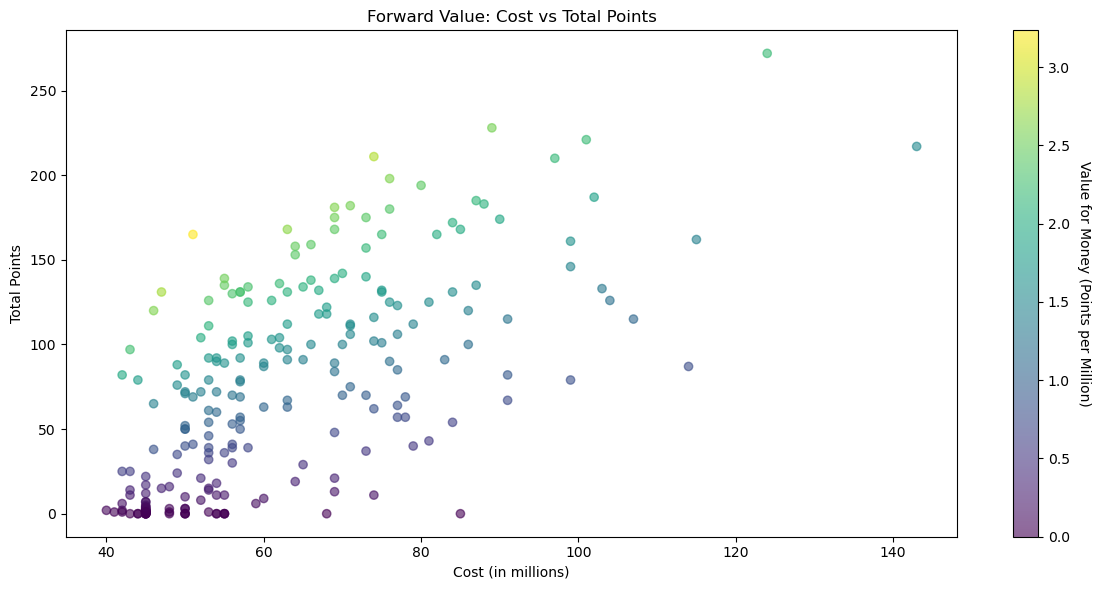

In [17]:
# Value for money: Compare cost vs points for forwards
plt.figure(figsize=(12, 6))
# Calculate value for money (points per million cost)
forwards_df['value_for_money'] = forwards_df['total_points'] / forwards_df['end_cost']

# Create scatter plot
plt.figure(figsize=(12, 6))
scatter = plt.scatter(forwards_df['end_cost'], forwards_df['total_points'], 
                      c=forwards_df['value_for_money'], cmap='viridis', alpha=0.6)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Value for Money (Points per Million)', rotation=270, labelpad=15)

# Customize plot
plt.title('Forward Value: Cost vs Total Points')
plt.xlabel('Cost (in millions)')
plt.ylabel('Total Points')

# Add annotations for top 5 value for money players
top_value_players = forwards_df.nlargest(5, 'value_for_money')
# for idx, player in top_value_players.iterrows():
    # plt.annotate(player['player_name'], 
    #              (player['end_cost'], player['total_points']),
    #              xytext=(5, 5), textcoords='offset points')

plt.tight_layout()



In [18]:
#save the dataframe processed
forwards_df.to_csv('../data/processed/forwards_processed.csv', index=False)